In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
with open("dialog_acts.dat", 'r') as file:
    data = {'label': [], 'sentence': [], 'prediction': []}
    
    for line in file:
        words = line.split(maxsplit=1)
        if len(words) > 1:
            data['label'].append(words[0])
            data['sentence'].append(words[1])
        else:
            data['label'].append(words[0])
            data['sentence'].append('')

In [3]:
for sentence in data["sentence"]:
    data["prediction"].append("inform")

In [4]:
if len(data['label']) != len(data['prediction']):
    print("Error: The number of labels and predictions do not match.")
else:
    correct = 0
    total = len(data['label'])

    for i in range(total):
        if data['label'][i] == data['prediction'][i]:
            correct += 1

    accuracy = correct / total * 100
    print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 39.84%


# Keywords

In [5]:
def count_labels(data):
    label_counts = {}

    # Count the occurrences of each label
    for label in data['label']:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

    # Print the count of each label
    for label, count in label_counts.items():
        print(f"{label}: {count}")

In [6]:
count_labels(data)

inform: 10160
confirm: 172
affirm: 1156
request: 6494
thankyou: 3259
null: 1612
bye: 266
reqalts: 1747
negate: 435
hello: 93
repeat: 33
ack: 28
restart: 14
deny: 27
reqmore: 5


In [7]:
# keywords = {
#     'ack': ['kay', 'okay'],
#     'affirm': ['yes', 'right', 'yeah'],
#     'bye': ['bye'],
#     'confirm': ['is it', 'does it', 'do they'],
#     'deny': ['wrong', 'dont want', 'no']
# }

In [8]:
keywords = {
    'ack': ['kay', 'okay'],
    'affirm': ['yes', 'right', 'yeah'],
    'thankyou': ['thank'],
    'bye': ['bye', 'goodbye'],
    'confirm': ['is it', 'does it', 'do they'],
    'deny': ['wrong', 'dont', 'not'],
    'hello': ['hi', 'hello', 'halo', 'welcome'],
    'inform': [
        'looking', 'restaurant', 'any', 'food', 'part', 'town', 'cheap', 'expensive', 
        'mediterranean', 'seafood', 'east', 'west', 'north', 'south', 'asian', 
        'oriental', 'scottish', 'matter', 'european', 'want', 'care', 'austrian', 
        'center', 'corsica', 'international', 'priced', 'moderately', 'moderate', 
        'central', 'eirtrean', 'spanish', 'venue', 'australian', 'turkish'
    ],
    'negate': ['no'],
    'null': [],
    'repeat': ['repeat', 'again', 'back'],
    'reqalts': ['how about', 'what about', 'is there', 'anything else'],
    'reqmore': ['more'],
    'request': ['address', 'phone', 'number', 'post code', 'how much', 'where', 'whats', 'what is', 'price range'],
    'restart': ['start', 'reset'],
}


In [9]:
# Not 2 word friendly

# def classify_sentence(sentence, keywords):
#     # Convert the sentence to lowercase and tokenize it
#     tokens = re.findall(r'\b\w+\b', sentence.lower())
    
#     # Check each label and its associated keywords
#     for label, kws in keywords.items():
#         # Check if any keyword is in the tokens
#         if any(keyword in tokens for keyword in kws):
#             return label
            
#     # Return 'null' if no keywords are found
#     return 'null'

In [10]:
def classify_sentence(sentence, keywords):
    # Convert the sentence to lowercase
    sentence_lower = sentence.lower()
    
    # Sort keywords by length in descending order to match longer phrases first
    sorted_keywords = sorted(((label, keyword) for label, kw_list in keywords.items() for keyword in kw_list),
                              key=lambda x: len(x[1]), reverse=True)
    
    # Check if any keyword is in the sentence
    for label, keyword in sorted_keywords:
        if keyword in sentence_lower:
            return label
    
    # Return 'null' if no keywords are found
    return 'null'

In [11]:
data['prediction'] = [classify_sentence(sentence, keywords) for sentence in data['sentence']]

In [12]:
def calculate_accuracy_filtered(labels, predictions):
    filtered_labels = []
    filtered_predictions = []
    
    for label, prediction in zip(labels, predictions):
        filtered_labels.append(label)
        filtered_predictions.append(prediction)
    
    if len(filtered_labels) != len(filtered_predictions):
        raise ValueError("Filtered labels and predictions lists must be of the same length.")
    
    correct = sum(1 for l, p in zip(filtered_labels, filtered_predictions) if l == p)
    total = len(filtered_labels)
    accuracy = (correct / total) * 100 if total > 0 else 0
    return accuracy

accuracy = calculate_accuracy_filtered(data['label'], data['prediction'])
print(accuracy)

81.48307909493745


In [13]:
from collections import defaultdict

def calculate_accuracy_per_label(labels, predictions):
    label_counts = defaultdict(int)  # To count occurrences of each label
    correct_counts = defaultdict(int)  # To count correct predictions for each label

    for label, prediction in zip(labels, predictions):
        label_counts[label] += 1
        if label == prediction:
            correct_counts[label] += 1

    accuracy_per_label = {}
    for label in label_counts:
        total = label_counts[label]
        correct = correct_counts[label]
        accuracy_per_label[label] = (correct / total) * 100 if total > 0 else 0
    
    return accuracy_per_label

accuracy_per_label = calculate_accuracy_per_label(data['label'], data['prediction'])

# Print or inspect the accuracy per label
for label, accuracy in accuracy_per_label.items():
    print(f"Label: {label}, Accuracy: {accuracy:.2f}%")


Label: inform, Accuracy: 79.60%
Label: confirm, Accuracy: 51.16%
Label: affirm, Accuracy: 80.62%
Label: request, Accuracy: 88.10%
Label: thankyou, Accuracy: 87.11%
Label: null, Accuracy: 61.29%
Label: bye, Accuracy: 74.44%
Label: reqalts, Accuracy: 85.00%
Label: negate, Accuracy: 70.11%
Label: hello, Accuracy: 49.46%
Label: repeat, Accuracy: 100.00%
Label: ack, Accuracy: 60.71%
Label: restart, Accuracy: 92.86%
Label: deny, Accuracy: 81.48%
Label: reqmore, Accuracy: 100.00%


In [14]:
# for label, sentence, prediction in zip(data['label'], data['sentence'], data['prediction']):
#     if label == 'confirm':
#         print(f"Sentence: {sentence}, Prediction: {prediction}")

In [15]:
def classify_sentence(sentence):
    for label, words in keywords.items():
        print('words')
        if any(word in sentence.lower() for word in words):
            return label
    return 'Unknown'  # Default label if no keywords are matched

In [16]:
# while True:
#     # Get user input
#     sentence = input("Enter a sentence to classify (or type 'exit' to stop): ")
    
#     # Exit condition
#     if sentence.lower() == 'exit':
#         print("Exiting the classifier.")
#         break
    
#     # Classify the sentence
#     label = classify_sentence(sentence)
#     print(f"Classified as: {label}")

# Feed Forward Neural Network

In [17]:
# Convert all labels to numbers
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

In [18]:
max_words = 10000  # Maximum number of words
max_len = 128  # Maximum sentence length

In [19]:
# Tokenize all words
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(data['sentence'])
sequences = tokenizer.texts_to_sequences(data['sentence'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

In [20]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    padded_sequences, data['label'], test_size=0.2, random_state=42
)

In [21]:
def create_model():
    model = models.Sequential()
    
    model.add(layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(15, activation='softmax'))  # 15 classes
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [22]:
model = create_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 128)          1280000   
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 256)               4194560   
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                                 
Total params: 5478415 (20.90 MB)
Trainable params: 5478415 (20.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
history = model.fit(train_sentences, train_labels, epochs=5, batch_size=16, validation_split=0.2)

Epoch 1/5


1020/1020 [==============================] - 32s 31ms/step - loss: 0.2977 - accuracy: 0.9172 - val_loss: 0.1024 - val_accuracy: 0.9713
Epoch 2/5
1020/1020 [==============================] - 31s 30ms/step - loss: 0.0743 - accuracy: 0.9795 - val_loss: 0.0789 - val_accuracy: 0.9794
Epoch 3/5
1020/1020 [==============================] - 32s 31ms/step - loss: 0.0435 - accuracy: 0.9873 - val_loss: 0.0787 - val_accuracy: 0.9792
Epoch 4/5
1020/1020 [==============================] - 32s 31ms/step - loss: 0.0262 - accuracy: 0.9920 - val_loss: 0.0839 - val_accuracy: 0.9792
Epoch 5/5
1020/1020 [==============================] - 33s 32ms/step - loss: 0.0198 - accuracy: 0.9947 - val_loss: 0.0849 - val_accuracy: 0.9809


In [24]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_sentences)
predicted_labels = np.argmax(predictions, axis=1)

# Ensure all 15 classes are included in the report
all_classes = list(range(15))

# Generate the classification report
report = classification_report(test_labels, predicted_labels, labels=all_classes, target_names=[f'{le.inverse_transform([i])[0]}' for i in all_classes])

print(report)


160/160 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         ack       0.33      0.20      0.25         5
      affirm       0.99      0.97      0.98       247
         bye       0.98      0.98      0.98        46
     confirm       0.84      0.94      0.89        33
        deny       0.62      0.71      0.67         7
       hello       1.00      1.00      1.00        16
      inform       0.98      0.99      0.99      2041
      negate       1.00      0.99      0.99        81
        null       0.97      0.92      0.94       309
      repeat       1.00      0.75      0.86         4
     reqalts       0.97      0.96      0.97       368
     reqmore       0.00      0.00      0.00         2
     request       0.99      1.00      0.99      1305
     restart       0.33      0.33      0.33         3
    thankyou       1.00      1.00      1.00       634

    accuracy                           0.98      5101
   macro avg       0.80  

C:\Users\storm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\storm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\storm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

160/160 [==============================] - 0s 2ms/step


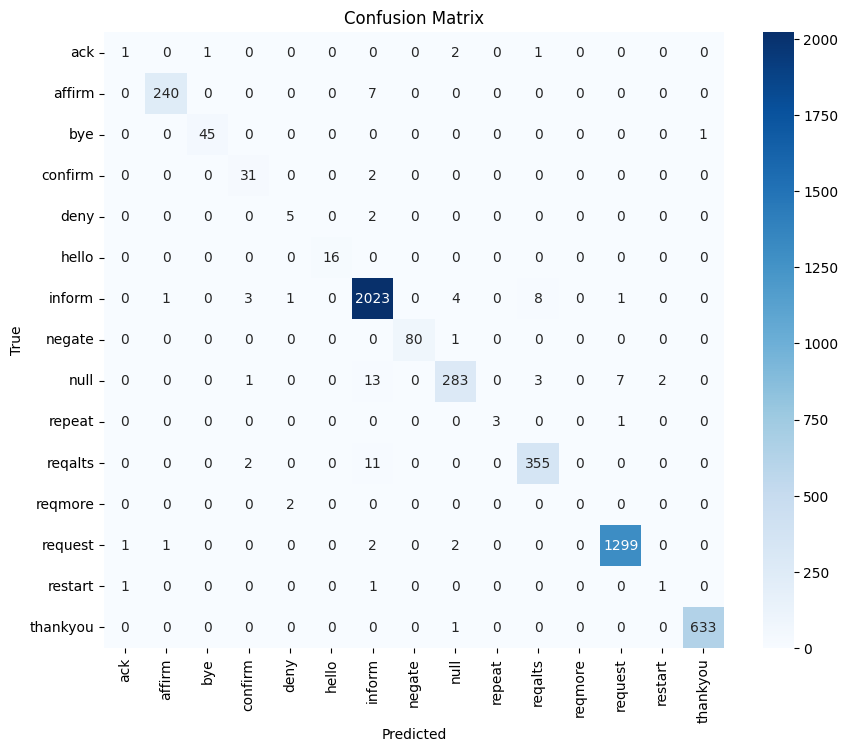

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predictions for the test set
y_pred = model.predict(test_sentences)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to predicted class labels

# Use test_labels directly if they are not one-hot encoded
y_true_labels = test_labels

# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Get the actual class names (the inverse transform from LabelEncoder)
class_names = le.inverse_transform(np.unique(y_true_labels))

# Plot the confusion matrix with actual labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [25]:
test_loss, test_acc = model.evaluate(test_sentences, test_labels)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

160/160 [==============================] - 1s 3ms/step - loss: 0.0619 - accuracy: 0.9831
Test Accuracy: 98.31%


In [26]:
unique_labels = sorted(list(set(data['label'])))

In [27]:
def classify_sentence_fnn(sentence):
    # Tokenize and pad the input sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=128, padding='post')
    
    # Get prediction from the model
    prediction = model.predict(padded_sequence)
    
    # Get the index of the highest probability
    predicted_label_index = np.argmax(prediction, axis=1)[0]
    predicted_label = le.inverse_transform([predicted_label_index])[0]

    return predicted_label

In [28]:
# while True:
#     sentence = input("Enter a sentence to classify (or type 'exit' to stop): ")
    
#     if sentence.lower() == 'exit':
#         print("Exiting the classifier.")
#         break
    
#     # Classify the sentence using the FNN model
#     label = classify_sentence_fnn(sentence)
    
#     print(f"Classified as: {label}")

### Deduplicate

In [29]:
df = pd.DataFrame(data)
df_cleaned = df.drop_duplicates(subset=['label', 'sentence'])
data_deduplicate = df_cleaned.to_dict(orient='list')
data_deduplicate['label'] = np.array(data_deduplicate['label'])

In [30]:
# Convert all labels to numbers
le_dedup = LabelEncoder()
data_deduplicate['label'] = le_dedup.fit_transform(data_deduplicate['label'])

In [31]:
print(len(data['sentence']))
print(len(data_deduplicate['sentence']))

25501
5359


In [32]:
# Tokenize all words
tokenizer_dedup = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer_dedup.fit_on_texts(data_deduplicate['sentence'])
sequences_dedup = tokenizer_dedup.texts_to_sequences(data_deduplicate['sentence'])
padded_sequences_dedup = pad_sequences(sequences_dedup, maxlen=max_len, padding='post')

In [33]:
train_sentences_dedup, test_sentences_dedup, train_labels_dedup, test_labels_dedup = train_test_split(
    padded_sequences_dedup, data_deduplicate['label'], test_size=0.2, random_state=42
)

In [34]:
model_deduplicate = create_model()
history_deduplicate = model_deduplicate.fit(train_sentences_dedup, train_labels_dedup, epochs=5, batch_size=16, validation_split=0.2)

Epoch 1/5
215/215 [==============================] - 7s 32ms/step - loss: 0.9216 - accuracy: 0.7404 - val_loss: 0.5238 - val_accuracy: 0.8543
Epoch 2/5
215/215 [==============================] - 7s 31ms/step - loss: 0.3770 - accuracy: 0.8909 - val_loss: 0.3882 - val_accuracy: 0.8753
Epoch 3/5
215/215 [==============================] - 7s 31ms/step - loss: 0.2410 - accuracy: 0.9315 - val_loss: 0.3435 - val_accuracy: 0.8974
Epoch 4/5
215/215 [==============================] - 7s 32ms/step - loss: 0.1679 - accuracy: 0.9510 - val_loss: 0.3344 - val_accuracy: 0.9009
Epoch 5/5
215/215 [==============================] - 7s 31ms/step - loss: 0.1212 - accuracy: 0.9618 - val_loss: 0.3142 - val_accuracy: 0.9044


In [35]:
test_loss_deduplicate, test_acc_deduplicate = model_deduplicate.evaluate(test_sentences_dedup, test_labels_dedup)
print(f"Test Accuracy: {test_acc_deduplicate * 100:.2f}%")

34/34 [==============================] - 0s 3ms/step - loss: 0.2793 - accuracy: 0.9067
Test Accuracy: 90.67%


In [41]:
# Make predictions on the test set
predictions_dedup = model_deduplicate.predict(test_sentences_dedup)
predicted_labels_dedup = np.argmax(predictions_dedup, axis=1)

# Ensure all 15 classes are included in the report
all_classes = list(range(15))

# Generate the classification report
report_dedup = classification_report(test_labels_dedup, predicted_labels_dedup, labels=all_classes, target_names=[f'{le.inverse_transform([i])[0]}' for i in all_classes])

print(report_dedup)

34/34 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         5
      affirm       0.97      0.91      0.94        34
         bye       0.80      0.33      0.47        12
     confirm       0.81      0.95      0.88        22
        deny       0.00      0.00      0.00         1
       hello       1.00      0.78      0.88         9
      inform       0.94      0.96      0.95       604
      negate       0.94      0.97      0.95        31
        null       0.55      0.58      0.56        59
      repeat       0.00      0.00      0.00         1
     reqalts       0.91      0.84      0.87        99
     reqmore       0.00      0.00      0.00         0
     request       0.93      0.95      0.94       176
     restart       0.00      0.00      0.00         1
    thankyou       0.80      0.89      0.84        18

   micro avg       0.91      0.91      0.91      1072
   macro avg       0.58    

C:\Users\storm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\storm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\storm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

34/34 [==============================] - 0s 2ms/step


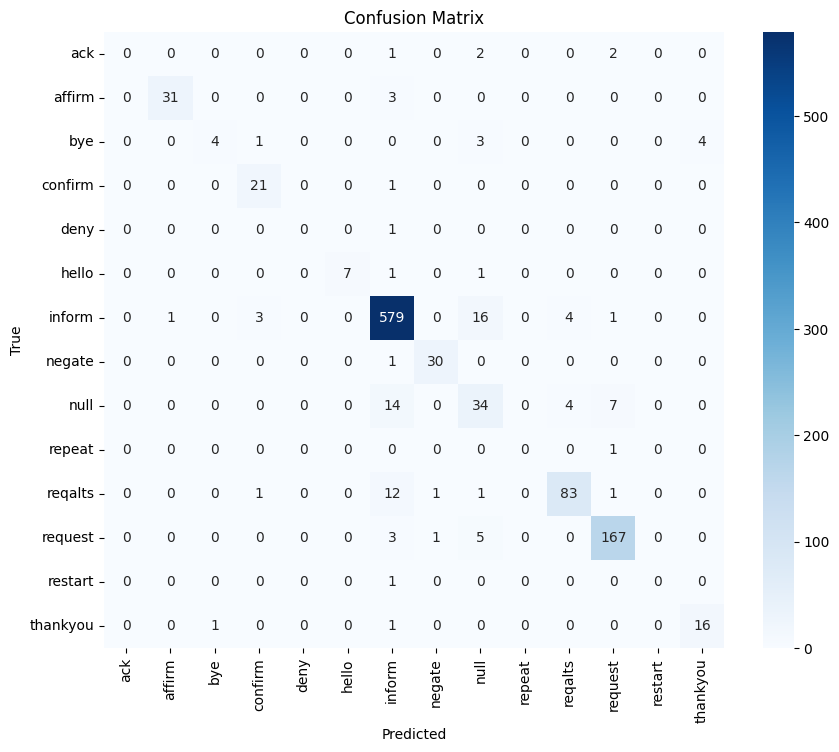

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predictions for the test set
y_pred = model_deduplicate.predict(test_sentences_dedup)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to predicted class labels

# Use test_labels directly if they are not one-hot encoded
y_true_labels = test_labels_dedup

# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Get the actual class names (the inverse transform from LabelEncoder)
class_names = le.inverse_transform(np.unique(y_true_labels))

# Plot the confusion matrix with actual labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [38]:
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrices_and_reports(cm_orig, cm_dedup, report_orig, report_dedup, classes):
    # Prepare classification reports
    df_report_orig = pd.DataFrame(report_orig).T
    df_report_dedup = pd.DataFrame(report_dedup).T

    # Remove 'support' column from reports for a cleaner view
    df_report_orig = df_report_orig.drop(columns='support', errors='ignore')
    df_report_dedup = df_report_dedup.drop(columns='support', errors='ignore')

    # Plot confusion matrices
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix - Original Data')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(2, 2, 2)
    sns.heatmap(cm_dedup, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix - Deduplicated Data')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot classification reports
    plt.subplot(2, 2, 3)
    sns.heatmap(df_report_orig, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Classification Report - Original Data')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 4)
    sns.heatmap(df_report_dedup, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Classification Report - Deduplicated Data')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Compute confusion matrices
cm_orig = confusion_matrix(y_true_orig, y_pred_orig, labels=list(label_map.values()))
cm_dedup = confusion_matrix(y_true_dedup, y_pred_dedup, labels=list(label_map.values()))

# Compute classification reports with zero_division handling
report_orig = classification_report(y_true_orig, y_pred_orig, output_dict=True, target_names=classes, zero_division=0)
report_dedup = classification_report(y_true_dedup, y_pred_dedup, output_dict=True, target_names=classes, zero_division=0)

# Plot the results
plot_confusion_matrices_and_reports(cm_orig, cm_dedup, report_orig, report_dedup, classes)


NameError: name 'y_true_orig' is not defined